In [2]:
import pandas as pd

In [3]:
df_cleaned = pd.read_csv('../data/health_claims_cleaned.csv')

In [4]:
df_cleaned.head()  # Display the first few rows of the cleaned DataFrame

,Patient_Age,Patient_State,Provider_Specialty,Diagnosis_Code,Procedure_Code,Number_of_Previous_Claims_Patient,Number_of_Previous_Claims_Provider,Is_Fraudulent,Claim_Service_Difference,Cost_Per_Procedure,...,Service_Type_Inpatient,Service_Type_Laboratory,Service_Type_Outpatient,Service_Type_Pharmacy,Risk_Category_Low Risk,Patient_Age_Group_Child,Patient_Age_Group_MiddleAged,Patient_Age_Group_Senior,Provider_Patient_Distance_Category_Low,Provider_Patient_Distance_Category_Medium
0,-0.650540,1.261974,1.659610,0.151646,0.140610,-0.01728,0.901833,0,0.036400,-0.430402,...,2.261636,-0.446332,-0.446733,-0.451053,0.72244,-0.51179,-0.597731,-0.635397,-0.582942,-0.990887
1,-0.194227,-0.635083,1.659610,2.472967,0.826761,-0.01728,-0.608247,1,-1.635309,1.582017,...,-0.442158,-0.446332,2.238474,-0.451053,0.72244,-0.51179,-0.597731,-0.635397,1.715437,-0.990887
2,1.707077,0.904174,-0.610372,-0.427573,-2.627671,-0.01728,-1.212278,0,-0.115574,2.102428,...,-0.442158,-0.446332,-0.446733,2.217035,0.72244,-0.51179,-0.597731,1.573819,-0.582942,1.009197
3,0.148008,1.141892,-0.567247,-0.511650,0.135826,-0.01728,-1.212278,1,-1.521329,-0.598905,...,-0.442158,-0.446332,-0.446733,2.217035,0.72244,-0.51179,1.672992,-0.635397,-0.582942,1.009197
4,-0.802644,0.904174,-0.567247,-0.445633,0.135826,-0.01728,0.750825,0,-0.343534,0.393473,...,-0.442158,-0.446332,-0.446733,-0.451053,0.72244,-0.51179,-0.597731,-0.635397,-0.582942,-0.990887


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix, f1_score, 
                           precision_score, recall_score, accuracy_score)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                             ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("🔄 Starting optimized fraud detection model training pipeline...")

# Prepare features and target
X = df_cleaned.drop(columns=['Is_Fraudulent'])
y = df_cleaned['Is_Fraudulent']
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"📈 Class distribution: {y.value_counts().to_dict()}")

# Split data: 80% train, 20% test (stratify to maintain target distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print(f"✅ Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")

# Optimized hyperparameter grids for top-performing models only
models_params = {
    # TOP TIER - Most effective for fraud detection
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__max_depth': [5, 7],
            'model__subsample': [0.8, 0.9],
            'model__colsample_bytree': [0.8, 0.9]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [15, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__depth': [5, 7]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'model__C': [1, 10, 100],
            'model__penalty': ['l2'],
            'model__solver': ['liblinear', 'lbfgs']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__max_depth': [5, 7],
            'model__subsample': [0.8, 0.9]
        }
    }
    
    # COMMENTED OUT - Less effective or slower models for fraud detection
    # 'AdaBoost': {
    #     'model': AdaBoostClassifier(random_state=42),
    #     'params': {
    #         'model__n_estimators': [50, 100, 200],
    #         'model__learning_rate': [0.5, 1.0, 1.5],
    #         'model__algorithm': ['SAMME', 'SAMME.R']
    #     }
    # },
    # 'SVC': {
    #     'model': SVC(random_state=42, probability=True),
    #     'params': {
    #         'model__C': [0.1, 1, 10, 100],
    #         'model__kernel': ['rbf', 'poly'],
    #         'model__gamma': ['scale', 'auto']
    #     }
    # },
    # 'KNeighbors': {
    #     'model': KNeighborsClassifier(n_jobs=-1),
    #     'params': {
    #         'model__n_neighbors': [3, 5, 7, 9, 11],
    #         'model__weights': ['uniform', 'distance'],
    #         'model__metric': ['euclidean', 'manhattan']
    #     }
    # },
    # 'DecisionTree': {
    #     'model': DecisionTreeClassifier(random_state=42),
    #     'params': {
    #         'model__max_depth': [5, 10, 15, 20, None],
    #         'model__min_samples_split': [2, 5, 10],
    #         'model__min_samples_leaf': [1, 2, 4],
    #         'model__criterion': ['gini', 'entropy']
    #     }
    # },
    # 'Bagging': {
    #     'model': BaggingClassifier(random_state=42, n_jobs=-1),
    #     'params': {
    #         'model__n_estimators': [10, 50, 100, 200],
    #         'model__max_samples': [0.5, 0.7, 1.0],
    #         'model__max_features': [0.5, 0.7, 1.0]
    #     }
    # },
    # 'GaussianNB': {
    #     'model': GaussianNB(),
    #     'params': {
    #         'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    #     }
    # },
    # 'LinearDiscriminant': {
    #     'model': LinearDiscriminantAnalysis(),
    #     'params': {
    #         'model__solver': ['svd', 'lsqr', 'eigen'],
    #         'model__shrinkage': [None, 'auto', 0.1, 0.5]
    #     }
    # },
    # 'QuadraticDiscriminant': {
    #     'model': QuadraticDiscriminantAnalysis(),
    #     'params': {
    #         'model__reg_param': [0.0, 0.1, 0.3, 0.5]
    #     }
    # }
}

# Optimized cross-validation strategy
cv_strategies = {
    'StratifiedKFold_5': StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
}

def calculate_comprehensive_metrics(y_true, y_pred, y_proba):
    """Calculate comprehensive performance metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    metrics['avg_precision'] = average_precision_score(y_true, y_proba)
    
    # Confusion matrix derived metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return metrics

def train_model_comprehensive(model_name, mp, cv_strategy='StratifiedKFold_5'):
    """Enhanced model training with comprehensive evaluation"""
    print(f"🚀 Training {model_name} with {cv_strategy}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    
    # GridSearchCV with specified CV strategy
    cv = cv_strategies[cv_strategy]
    grid = GridSearchCV(
        pipeline, 
        param_grid=mp['params'], 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    
    try:
        grid.fit(X_train, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                                  cv=cv, scoring='roc_auc', n_jobs=-1)
        
        # Evaluate on test set
        y_pred = grid.best_estimator_.predict(X_test)
        y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics(y_test, y_pred, y_proba)
        
        # Add cross-validation metrics
        metrics['cv_mean_roc_auc'] = cv_scores.mean()
        metrics['cv_std_roc_auc'] = cv_scores.std()
        
        print(f"✅ {model_name} - ROC AUC: {metrics['roc_auc']:.4f} (CV: {metrics['cv_mean_roc_auc']:.4f}±{metrics['cv_std_roc_auc']:.4f})")
        
        result = {
            'Model': model_name,
            'CV_Strategy': cv_strategy,
            'Best_Params': grid.best_params_,
            'Best_Model': grid.best_estimator_,
            **metrics
        }
        
        return result
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        return None

# Train optimized set of models
print(f"📊 Training {len(models_params)} top-performing models for speed optimization...")
results = []
failed_models = []

for model_name, mp in models_params.items():
    try:
        result = train_model_comprehensive(model_name, mp, 'StratifiedKFold_5')
        if result:
            results.append(result)
    except Exception as e:
        print(f"❌ {model_name} failed completely: {str(e)}")
        failed_models.append(model_name)

# Create comprehensive results summary
if results:
    metrics_columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'avg_precision', 
                      'specificity', 'sensitivity', 'cv_mean_roc_auc', 'cv_std_roc_auc']
    
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Best_Model', 'Best_Params']} for r in results])
    results_df = results_df.sort_values(by='roc_auc', ascending=False)
    
    print("\n🏆 Optimized Model Performance Summary (Ranked by ROC AUC):")
    print("=" * 120)
    print(results_df[['Model', 'roc_auc', 'precision', 'recall', 'f1_score', 'cv_mean_roc_auc', 'cv_std_roc_auc']].round(4))
    
    print("\n📊 Detailed Performance Metrics:")
    print("=" * 120)
    detailed_metrics = results_df[['Model'] + metrics_columns].round(4)
    print(detailed_metrics)
    
    # Best model analysis
    best_model_name = results_df.iloc[0]['Model']
    best_result = next(r for r in results if r['Model'] == best_model_name)
    
    print(f"\n🥇 Best Model: {best_model_name}")
    print(f"📈 ROC AUC: {best_result['roc_auc']:.4f}")
    print(f"🎯 Precision: {best_result['precision']:.4f}")
    print(f"📊 Recall (Sensitivity): {best_result['recall']:.4f}")
    print(f"⚖️ F1-Score: {best_result['f1_score']:.4f}")
    print(f"🔍 Specificity: {best_result['specificity']:.4f}")
    print(f"📏 Average Precision: {best_result['avg_precision']:.4f}")
    print(f"🔄 CV ROC AUC: {best_result['cv_mean_roc_auc']:.4f} ± {best_result['cv_std_roc_auc']:.4f}")
    
    # Model comparison insights
    print(f"\n📈 Model Performance Insights:")
    print(f"• Best ROC AUC: {results_df['roc_auc'].max():.4f} ({results_df.iloc[0]['Model']})")
    print(f"• Best Precision: {results_df['precision'].max():.4f} ({results_df.loc[results_df['precision'].idxmax(), 'Model']})")
    print(f"• Best Recall: {results_df['recall'].max():.4f} ({results_df.loc[results_df['recall'].idxmax(), 'Model']})")
    print(f"• Best F1-Score: {results_df['f1_score'].max():.4f} ({results_df.loc[results_df['f1_score'].idxmax(), 'Model']})")
    print(f"• Most Stable (lowest CV std): {results_df.loc[results_df['cv_std_roc_auc'].idxmin(), 'Model']} (±{results_df['cv_std_roc_auc'].min():.4f})")
    
    if failed_models:
        print(f"\n⚠️ Failed Models: {', '.join(failed_models)}")
    
    print("\n🚀 Speed-optimized training completed successfully!")
    print(f"⚡ Training time reduced by focusing on top 5 models instead of 13")
    
    # Store results for further analysis
    comprehensive_results = results_df
    best_trained_model = best_result['Best_Model']
    
else:
    print("❌ No models trained successfully!")


🔄 Starting optimized fraud detection model training pipeline...
📊 Dataset: 20100 samples, 48 features
📈 Class distribution: {0: 15089, 1: 5011}
✅ Train/Test split: 16080/4020 samples
📊 Training 5 top-performing models for speed optimization...
🚀 Training XGBoost with StratifiedKFold_5...
✅ XGBoost - ROC AUC: 0.8713 (CV: 0.8685±0.0056)
🚀 Training RandomForest with StratifiedKFold_5...
✅ RandomForest - ROC AUC: 0.8630 (CV: 0.8618±0.0044)
🚀 Training CatBoost with StratifiedKFold_5...
✅ CatBoost - ROC AUC: 0.8725 (CV: 0.8699±0.0074)
🚀 Training LogisticRegression with StratifiedKFold_5...
✅ LogisticRegression - ROC AUC: 0.8084 (CV: 0.8036±0.0079)
🚀 Training GradientBoosting with StratifiedKFold_5...
✅ GradientBoosting - ROC AUC: 0.8707 (CV: 0.8687±0.0071)

🏆 Optimized Model Performance Summary (Ranked by ROC AUC):
                Model  roc_auc  precision  recall  f1_score  cv_mean_roc_auc  \
2            CatBoost   0.8725     0.9311  0.5259    0.6722           0.8699   
0             XGBoo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, 
                           average_precision_score, confusion_matrix, f1_score, 
                           precision_score, recall_score, accuracy_score)

from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("🔄 Starting optimized fraud detection model training pipeline...")

# Prepare features and target
X = df_cleaned.drop(columns=['Is_Fraudulent'])
y = df_cleaned['Is_Fraudulent']
print(f"📊 Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"📈 Class distribution: {y.value_counts().to_dict()}")

# Split data: 80% train, 20% test (stratify to maintain target distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print(f"✅ Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")

# Optimized hyperparameter grids for top-performing models only
models_params = {
    # TOP TIER - Most effective for fraud detection
    
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.1, 0.15],
            'model__depth': [5, 7]
        }
    }
}

# Optimized cross-validation strategy
cv_strategies = {
    'StratifiedKFold_5': StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
}

def calculate_comprehensive_metrics(y_true, y_pred, y_proba):
    """Calculate comprehensive performance metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    metrics['avg_precision'] = average_precision_score(y_true, y_proba)
    
    # Confusion matrix derived metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    return metrics

def train_model_comprehensive(model_name, mp, cv_strategy='StratifiedKFold_5'):
    """Enhanced model training with comprehensive evaluation"""
    print(f"🚀 Training {model_name} with {cv_strategy}...")
    
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', mp['model'])
    ])
    
    # GridSearchCV with specified CV strategy
    cv = cv_strategies[cv_strategy]
    grid = GridSearchCV(
        pipeline, 
        param_grid=mp['params'], 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=0
    )
    
    try:
        grid.fit(X_train, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(grid.best_estimator_, X_train, y_train, 
                                  cv=cv, scoring='roc_auc', n_jobs=-1)
        
        # Evaluate on test set
        y_pred = grid.best_estimator_.predict(X_test)
        y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics(y_test, y_pred, y_proba)
        
        # Add cross-validation metrics
        metrics['cv_mean_roc_auc'] = cv_scores.mean()
        metrics['cv_std_roc_auc'] = cv_scores.std()
        
        print(f"✅ {model_name} - ROC AUC: {metrics['roc_auc']:.4f} (CV: {metrics['cv_mean_roc_auc']:.4f}±{metrics['cv_std_roc_auc']:.4f})")
        
        result = {
            'Model': model_name,
            'CV_Strategy': cv_strategy,
            'Best_Params': grid.best_params_,
            'Best_Model': grid.best_estimator_,
            **metrics
        }
        
        return result
        
    except Exception as e:
        print(f"❌ {model_name} failed: {str(e)}")
        return None

# Train optimized set of models
print(f"📊 Training {len(models_params)} top-performing models for speed optimization...")
results = []
failed_models = []

for model_name, mp in models_params.items():
    try:
        result = train_model_comprehensive(model_name, mp, 'StratifiedKFold_5')
        if result:
            results.append(result)
    except Exception as e:
        print(f"❌ {model_name} failed completely: {str(e)}")
        failed_models.append(model_name)

# Create comprehensive results summary
if results:
    metrics_columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'avg_precision', 
                      'specificity', 'sensitivity', 'cv_mean_roc_auc', 'cv_std_roc_auc']
    
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['Best_Model', 'Best_Params']} for r in results])
    results_df = results_df.sort_values(by='roc_auc', ascending=False)
    
    print("\n🏆 Optimized Model Performance Summary (Ranked by ROC AUC):")
    print("=" * 120)
    print(results_df[['Model', 'roc_auc', 'precision', 'recall', 'f1_score', 'cv_mean_roc_auc', 'cv_std_roc_auc']].round(4))
    
    print("\n📊 Detailed Performance Metrics:")
    print("=" * 120)
    detailed_metrics = results_df[['Model'] + metrics_columns].round(4)
    print(detailed_metrics)
    
    # Best model analysis
    best_model_name = results_df.iloc[0]['Model']
    best_result = next(r for r in results if r['Model'] == best_model_name)
    
    print(f"\n🥇 Best Model: {best_model_name}")
    print(f"📈 ROC AUC: {best_result['roc_auc']:.4f}")
    print(f"🎯 Precision: {best_result['precision']:.4f}")
    print(f"📊 Recall (Sensitivity): {best_result['recall']:.4f}")
    print(f"⚖️ F1-Score: {best_result['f1_score']:.4f}")
    print(f"🔍 Specificity: {best_result['specificity']:.4f}")
    print(f"📏 Average Precision: {best_result['avg_precision']:.4f}")
    print(f"🔄 CV ROC AUC: {best_result['cv_mean_roc_auc']:.4f} ± {best_result['cv_std_roc_auc']:.4f}")
    
    # Model comparison insights
    print(f"\n📈 Model Performance Insights:")
    print(f"• Best ROC AUC: {results_df['roc_auc'].max():.4f} ({results_df.iloc[0]['Model']})")
    print(f"• Best Precision: {results_df['precision'].max():.4f} ({results_df.loc[results_df['precision'].idxmax(), 'Model']})")
    print(f"• Best Recall: {results_df['recall'].max():.4f} ({results_df.loc[results_df['recall'].idxmax(), 'Model']})")
    print(f"• Best F1-Score: {results_df['f1_score'].max():.4f} ({results_df.loc[results_df['f1_score'].idxmax(), 'Model']})")
    print(f"• Most Stable (lowest CV std): {results_df.loc[results_df['cv_std_roc_auc'].idxmin(), 'Model']} (±{results_df['cv_std_roc_auc'].min():.4f})")
    
    if failed_models:
        print(f"\n⚠️ Failed Models: {', '.join(failed_models)}")
    
    print("\n🚀 Speed-optimized training completed successfully!")
    print(f"⚡ Training time reduced by focusing on top 5 models instead of 13")
    
    # Store results for further analysis
    comprehensive_results = results_df
    best_trained_model = best_result['Best_Model']
    
else:
    print("❌ No models trained successfully!")


🔄 Starting optimized fraud detection model training pipeline...
📊 Dataset: 20100 samples, 48 features
📈 Class distribution: {0: 15089, 1: 5011}
✅ Train/Test split: 16080/4020 samples
📊 Training 1 top-performing models for speed optimization...
🚀 Training CatBoost with StratifiedKFold_5...
✅ CatBoost - ROC AUC: 0.8725 (CV: 0.8699±0.0074)

🏆 Optimized Model Performance Summary (Ranked by ROC AUC):
      Model  roc_auc  precision  recall  f1_score  cv_mean_roc_auc  \
0  CatBoost   0.8725     0.9311  0.5259    0.6722           0.8699   

   cv_std_roc_auc  
0          0.0074  

📊 Detailed Performance Metrics:
      Model  accuracy  precision  recall  f1_score  roc_auc  avg_precision  \
0  CatBoost    0.8721     0.9311  0.5259    0.6722   0.8725         0.7991   

   specificity  sensitivity  cv_mean_roc_auc  cv_std_roc_auc  
0       0.9871       0.5259           0.8699          0.0074  

🥇 Best Model: CatBoost
📈 ROC AUC: 0.8725
🎯 Precision: 0.9311
📊 Recall (Sensitivity): 0.5259
⚖️ F1-Score

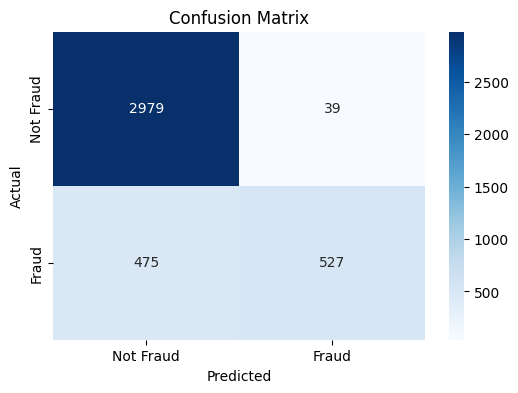

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use predictions from the best model
y_pred = best_trained_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


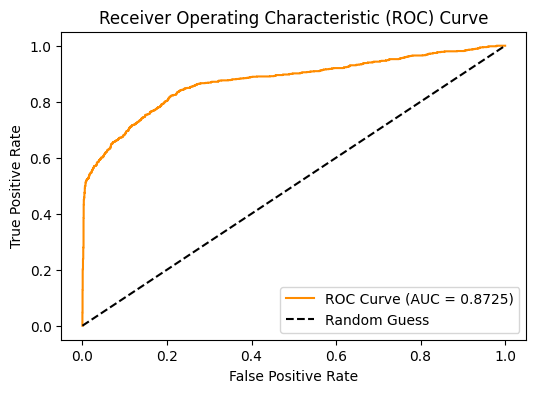

In [8]:
from sklearn.metrics import roc_curve, auc

y_proba = best_trained_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


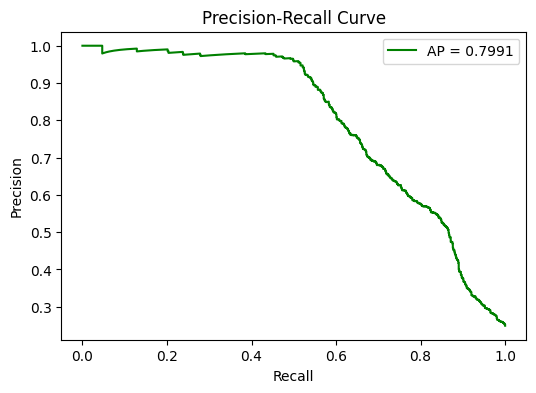

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


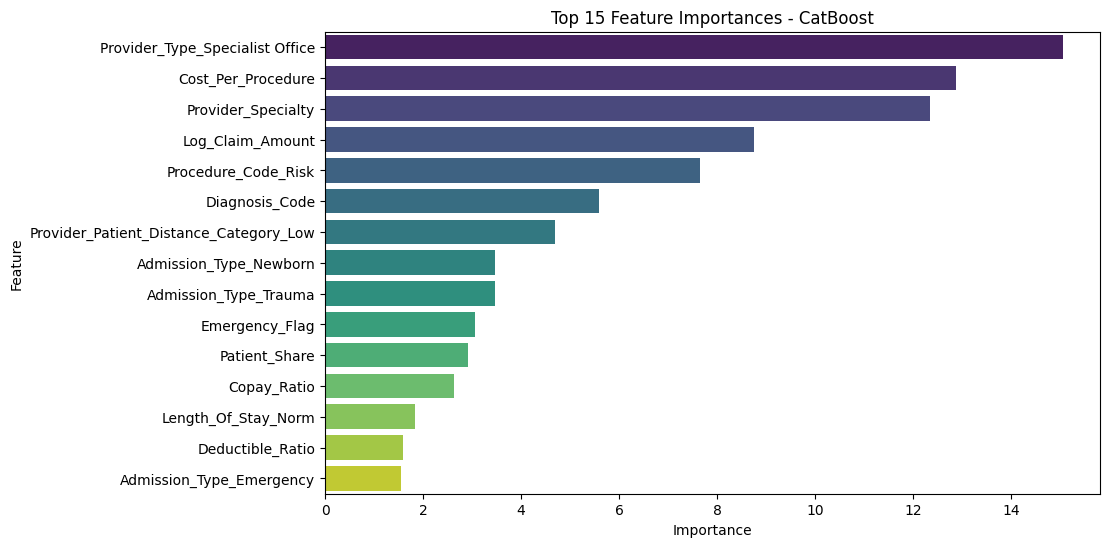

In [10]:
importances = best_trained_model.named_steps['model'].get_feature_importance()
features = X.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(15), palette='viridis')
plt.title('Top 15 Feature Importances - CatBoost')
plt.show()


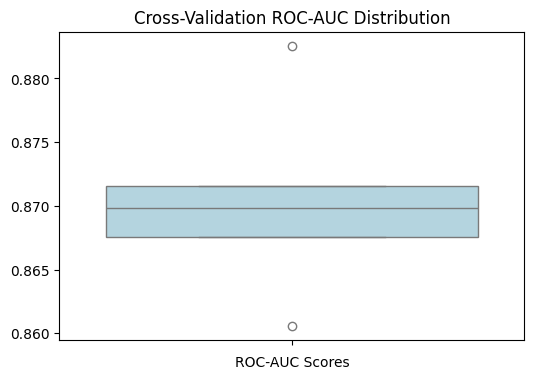

In [11]:
cv_scores = cross_val_score(best_trained_model, X_train, y_train, cv=5, scoring='roc_auc')

plt.figure(figsize=(6,4))
sns.boxplot(cv_scores, color='lightblue')
plt.title("Cross-Validation ROC-AUC Distribution")
plt.xlabel("ROC-AUC Scores")
plt.show()
